In [1]:
from data.distances.gmd import _compute_gmd
from data.distances.OCTADataset import OCTADataset
import os
import torch
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
from time import time

from torch_geometric.utils import to_networkx
from multiprocessing import Pool
import networkx as nx
import torch

from time import time
from multiprocessing import Pool, cpu_count
from torch_geometric.utils import to_networkx, from_networkx

# GDD

In [15]:
# adapted from https://github.com/sushovan4/ggdlib/blob/main/src/gdd.py

import numpy as np
it = 0
def ggd(args):
    '''
    pi encodes a matching; it's a map from V(g1) to V(g2). A non-negative entry
    (e.g. pi[i] = j) indicates that the ith vertex of g1 is mapped to the jth
    vertex of g2. If j = -1, then the vertex of g1 is deleted.
    '''
    data_pair, C_V, C_E = args
    G1 = to_networkx(data_pair[0], node_attrs=["pos"]).to_undirected()
    G2 = to_networkx(data_pair[1], node_attrs=["pos"]).to_undirected()
    
    swapped = False
    if G1.number_of_nodes() > G2.number_of_nodes():
        G1, G2 = G2, G1
        swapped = True
    
    n1, n2 = G1.number_of_nodes(), G2.number_of_nodes()
    
    if swapped:    
        v1 = data_pair[1].pos
        v2 = data_pair[0].pos
    else:
        v1 = data_pair[0].pos
        v2 = data_pair[1].pos
        
    m1, m2 = nx.adjacency_matrix(G1), nx.adjacency_matrix(G2)
    
    pi = np.zeros(n1, dtype = np.int32)

    # Define the cost of a matching pi
    def compute_cost(pi):
        cost = 0
        for i, j in enumerate(pi):
            # Vertex translation
            if j != -1:
                cost += C_V * np.linalg.norm(v1[i]- v2[j])

        for i in range(n1):
            for j in range(i + 1, n1):                
                if m1[i, j] == 1:
                    if pi[i] == -1 or pi[j] == -1 or m2[pi[i], pi[j]] == 0:
                        # Edge deletion from g1
                        cost += C_E * np.linalg.norm(v1[i] - v1[j])
                    else:
                        # Edge translation
                        cost += C_E * abs(
                            np.linalg.norm(v1[i] - v1[j]) - 
                            np.linalg.norm(v2[pi[i]] - v2[pi[j]])
                        )

        for i in range(n2):
            for j in range(i + 1, n2):
                if m2[i, j] == 1:    
                    if i not in pi or j not in pi or m1[np.where(pi == i)[0][0], np.where(pi == j)[0][0]] == 0:
                        # Edge deletion from g2
                        cost += C_E * np.linalg.norm(v2[i] - v2[j])
        #print(cost, pi)
        return cost
 
    # Define the recursion
    def recurse(k, pi):
        global it
        it += 1
        if k == n1 - 1:
            return ( compute_cost(pi), pi )

        k += 1
        pi[k] = -1
        res, pi_opt = recurse(k, np.copy(pi))

        for m in range(n2):
            if k > 0 and m in pi[0:k - 1]:
                continue
            pi[k] = m
            res1, pi1 = recurse(k, np.copy(pi))
        
            if res1 < res:
                res = res1
                pi_opt = pi1
        return (res, pi_opt)

    cost_opt, pi_opt = recurse(-1, pi)
    
    print(cost_opt)
    global it
    print('it', it)
    flow_opt = []
    for i in range(n1):
        if pi_opt[i] != -1:
            flow_opt.append( ('g1.' + str(i), 'g2.' + str(pi_opt[i])) )

    return {'pair': data_pair, 'ggd': cost_opt, 'ggd_flow': flow_opt, 'swapped': swapped}

In [45]:
def vis_mapping(G1, G2, flow, shift, flow2):
    mapping = {node: 'g1.' + str(node) for node in G1.nodes}
    G1 = nx.relabel_nodes(G1, mapping)
    mapping = {node: 'g2.' + str(node) for node in G2.nodes}
    G2 = nx.relabel_nodes(G2, mapping)
    
    for u in flow.values():
        for v, w in u.items():
            u[v] = { 'weight': w } 
    F = nx.DiGraph(flow)
    F.remove_node("eps1")
    F.remove_node("eps2")
    F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="weight") if w == 0])
    pos1 = nx.get_node_attributes(G1,'pos')
    pos2 = nx.get_node_attributes(G2,'pos')
    
    H = nx.DiGraph(flow2)

    for k in pos2.keys():
            pos2[k] = np.add( pos2[k], (shift,0))
    pos = pos1 | pos2
    
    plt.figure(figsize=(6, 4))

    nx.draw(G1, pos1, edge_color = "red", node_color = "red", node_size = 20)
    nx.draw(G2, pos2, edge_color = "blue", node_color = "blue", node_size = 20)
    nx.draw(F, pos, edge_color = "gray", width = 1, style = '--', node_size = 0, alpha = 0.5, connectionstyle="arc3, rad=0.2", arrowsize = 17)
    nx.draw(H, pos, edge_color = "green", width = 1, style = '--', node_size = 0, alpha = 0.5, connectionstyle="arc3, rad=0.3", arrowsize = 17)

In [35]:
def random_pos_shift(graph, radius):
    for node, attributes in graph.nodes(data=True):
        if 'pos' in attributes:
            current_position = np.array(attributes['pos'])
            shift = np.random.uniform(-radius, radius, size=(2,))
            new_position = current_position + shift
            graph.nodes[node]['pos'] = new_position
            
def e2e_ggd(dataset, id_1, id_2, remove=0, random_radius=None, C_V=1.0, C_E=1.0, multiplier=1.0, shift=1):
    G1 = to_networkx(dataset[id_1], node_attrs=["pos"]).to_undirected()
    G2 = to_networkx(dataset[id_2], node_attrs=["pos"]).to_undirected()
    
    if random_radius is not None:
        random_pos_shift(G2, random_radius)
    
    nn = G2.number_of_nodes()

    for i in range(1, remove + 1):
        G2.remove_node(nn - i)
    
    start_time = time()
    res_ggd = ggd(((from_networkx(G1), from_networkx(G2)), C_V, C_E))
    end_time = time()
    execution_time = end_time - start_time
    print(f"GGD execution time: {execution_time:.2f} seconds")
    
    start_time = time()
    res_gmd = _compute_gmd(((from_networkx(G1), from_networkx(G2)), C_V, C_E, multiplier))
    end_time = time()
    execution_time = end_time - start_time
    print(f"GMD execution time: {execution_time:.2f} seconds")
    
    ged = nx.graph_edit_distance(G1, G2, timeout=10)
    
    print(f"GGD: {res_ggd['ggd']}, GMD: {res_gmd['gmd']}, GED: {ged}")
    
    vis_mapping(G1, G2, res_gmd['gmd_flow'], shift, res_ggd['ggd_flow'])

In [10]:
dataset = OCTADataset()

/tmp/ipykernel_14777/724499674.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  m1, m2 = nx.adjacency_matrix(G1), nx.adjacency_matrix(G2)


0.0
it 6007881
GGD execution time: 6636.10 seconds
GMD execution time: 0.02 seconds
GGD: 0.0, GMD: 0.0, GED: 0.0


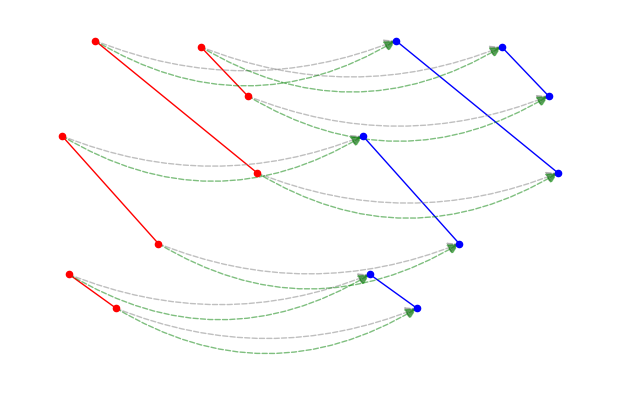

In [47]:
e2e_ggd(dataset, 1, 1, C_V=1.0, C_E=10.0, multiplier=1.0, shift=1)

/tmp/ipykernel_14777/724499674.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  m1, m2 = nx.adjacency_matrix(G1), nx.adjacency_matrix(G2)


8.352687507867813
it 6231672
GGD execution time: 208.92 seconds
GMD execution time: 0.01 seconds
GGD: 8.352687507867813, GMD: 8.0, GED: 4.0


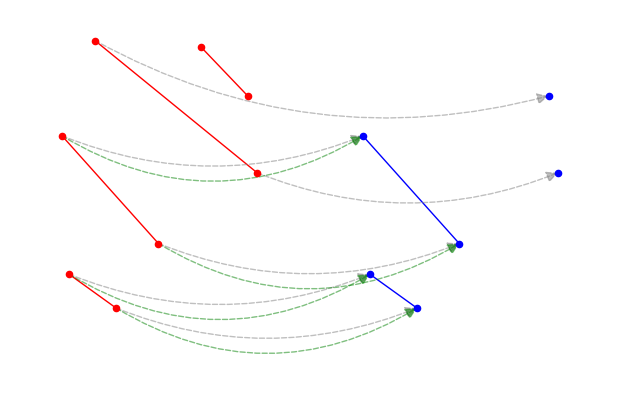

In [48]:
e2e_ggd(dataset, 1, 1, remove=2, C_V=1.0, C_E=10.0, multiplier=1.0, shift=1)

/tmp/ipykernel_14777/724499674.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  m1, m2 = nx.adjacency_matrix(G1), nx.adjacency_matrix(G2)


0.0
it 6273685
GGD execution time: 29.29 seconds
GMD execution time: 0.01 seconds
GGD: 0.0, GMD: 0.0, GED: 0.0


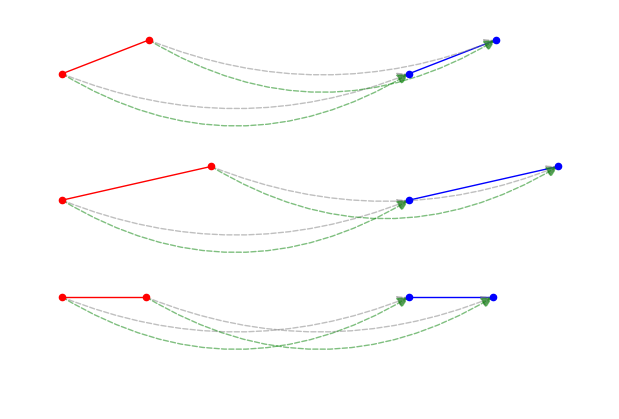

In [49]:
e2e_ggd(dataset, 15, 15, C_V=1.0, C_E=10.0, multiplier=1.0, shift=1)

/tmp/ipykernel_14777/724499674.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  m1, m2 = nx.adjacency_matrix(G1), nx.adjacency_matrix(G2)


2.576940953731537
it 6283441
GGD execution time: 5.98 seconds
GMD execution time: 0.01 seconds
GGD: 2.576940953731537, GMD: 4.0, GED: 2.0


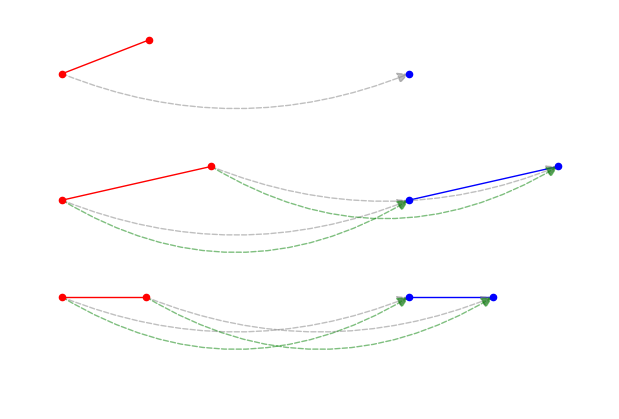

In [50]:
e2e_ggd(dataset, 15, 15, remove=1, C_V=1.0, C_E=10.0, multiplier=1.0, shift=1)

/tmp/ipykernel_14777/724499674.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  m1, m2 = nx.adjacency_matrix(G1), nx.adjacency_matrix(G2)


4.145010300969949
it 275368
GGD execution time: 5.93 seconds
GMD execution time: 0.01 seconds
GGD: 4.145010300969949, GMD: 4.0, GED: 2.0


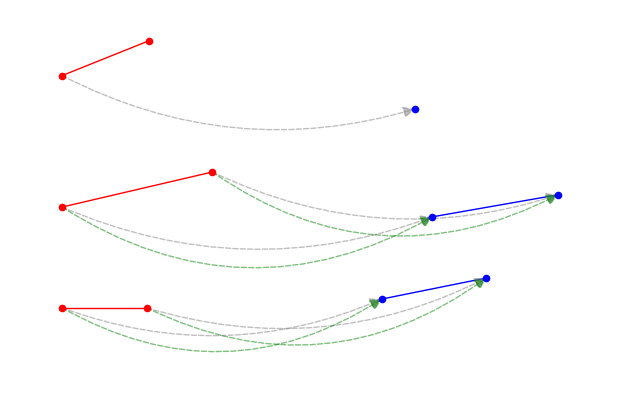

In [46]:
e2e_ggd(dataset, 15, 15, remove=1, random_radius=0.1, C_V=1.0, C_E=10.0, multiplier=1.0, shift=1)

In [1]:
6636 / 60


110.6